In [1]:
import requests
from PIL import Image
import io
import base64
from IPython.display import display
import pandas as pd
from pathlib import Path
import wikipedia
import urllib.request
import tqdm
import nature_go_client
import matplotlib.pyplot as plt
import sys
import rembg

In [5]:
# Nature Go parameters
NG_USERNAME = input()
NG_PASSWORD = input()

# Stable Diffusion parameters
SD_HOST = 'http://nature-go.edouardleurent.com'
STEPS = 20
WIDTH = 1024
HEIGHT = 1024
# SAMPLER = 'DPM++ 2M Karras'
PROMPT = "{commonNames} {scientificNameWithoutAuthor}, herbarium illustration, 19th century, transactions of the Botanical Society of London"


## Retrieve species with missing images through Nature go API

In [6]:
client = nature_go_client.NatureGoClient(username=NG_USERNAME, password=NG_PASSWORD)
client.login()

In [24]:
species_list = client.get_labeled_species(illustration=False, limit=5)
print(f'Found {len(species_list)} species')
species_list = pd.DataFrame(species_list)
species_list

id scientificNameWithoutAuthor  \
0   1              Prunus spinosa   
1   2          Alliaria petiolata   
2   3          Crataegus monogyna   
3   4            Cornus sanguinea   
4   5              Sambucus nigra   

                                         commonNames      genus        family  \
0  [Blackthorn, Sloe, Sloe Berry, Sloe Of Europe,...     Prunus      Rosaceae   
1  [Garlic Mustard, Jack-by-the-hedge, Hedge-Garl...   Alliaria  Brassicaceae   
2  [Hawthorn, Common Hawthorn, Red hawthorn, Engl...  Crataegus      Rosaceae   
3  [Common Dogwood, Dogwood, Pegwood, Red dogwood...     Cornus     Cornaceae   
4  [Common Elder, Black elderberry, Elderberry, C...   Sambucus   Viburnaceae   

     gbif_id     powo_id  wikipedia_word_count  number_of_occurrences  \
0  3023221.0    730297-1                  1269                  10581   
1  5376075.0   1176324-2                  1167                   8788   
2  9220780.0    723820-1                  1326                   8362   
3  3082234.0    271661-1                   462                   8178   
4  2888728.0  30122169-2                  1091                   7923   

   occurences_cdf  rarity_gpt descriptions illustration  \
0        0.993512         3.8           []         None   
1        0.988123         2.0           []         None   
2        0.982995         4.0           []         None   
3        0.977980         3.4           []         None   
4        0.973122         2.0           []         None   

  illustration_transparent reference_image_url  \
0                     None                       
1                     None                       
2                     None                       
3                     None                       
4                     None                       

                                    illustration_url    display_name  \
0  http://nature-go.edouardleurent.com/static/img...      Blackthorn   
1  http://nature-go.edouardleurent.com/static/img...  Garlic Mustard   
2  http://nature-go.edouardleurent.com/static/img...        Hawthorn   
3  http://nature-go.edouardleurent.com/static/img...  Common Dogwood   
4  http://nature-go.edouardleurent.com/static/img...    Common Elder   

   num_observations_total  num_questions_total  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0

## Select species

In [8]:
species = species_list.iloc[0]
species

id                                                                             1
scientificNameWithoutAuthor                                       Prunus spinosa
commonNames                    [Blackthorn, Sloe, Sloe Berry, Sloe Of Europe,...
genus                                                                     Prunus
family                                                                  Rosaceae
gbif_id                                                                3023221.0
powo_id                                                                 730297-1
wikipedia_word_count                                                        1269
number_of_occurrences                                                      10581
occurences_cdf                                                          0.993512
rarity_gpt                                                                   3.8
descriptions                                                                  []
illustration                

## Get a reference image

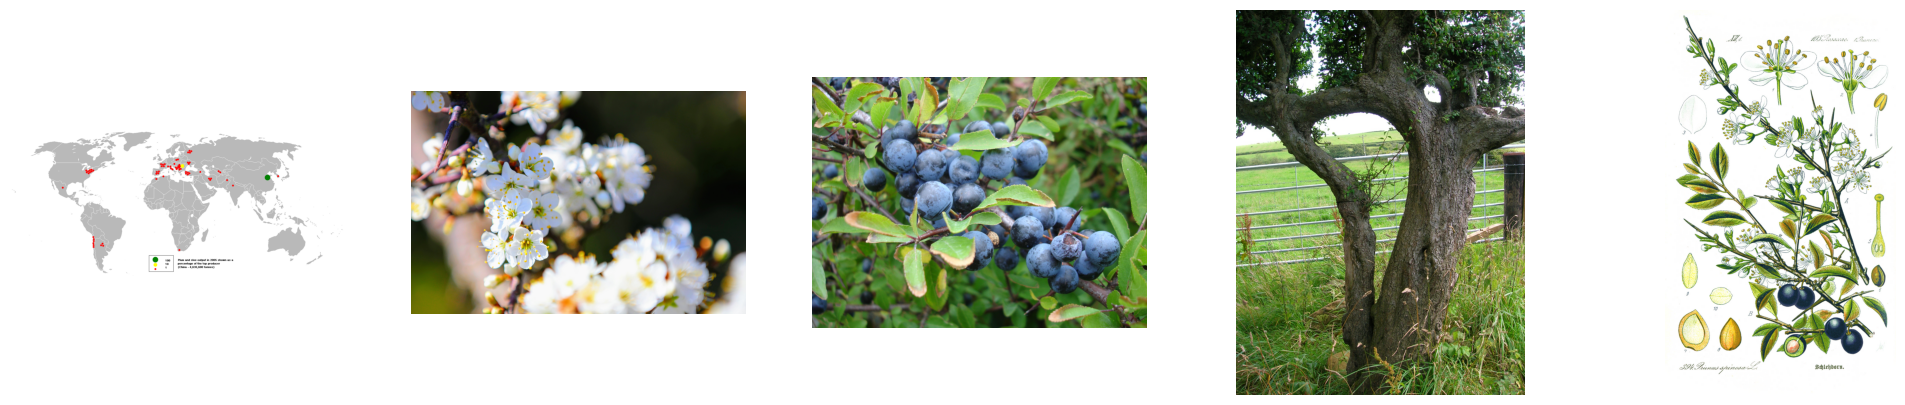

In [19]:
def download_image(url):
    with urllib.request.urlopen(url) as url:
        img = Image.open(io.BytesIO(url.read()))
        return img

def fetch_wikipedia_images(scientific_name):
    page = wikipedia.page(scientific_name)
    return page.images[:5]
    
    
def display_images(*images):
    _, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5), squeeze=False)
    for i, image in enumerate(images):
        axes.flat[i].imshow(image)
        axes.flat[i].axis('off')


reference_images_url = fetch_wikipedia_images(species.scientificNameWithoutAuthor)
reference_images = [download_image(img) for img in reference_images_url]
display_images(*reference_images)

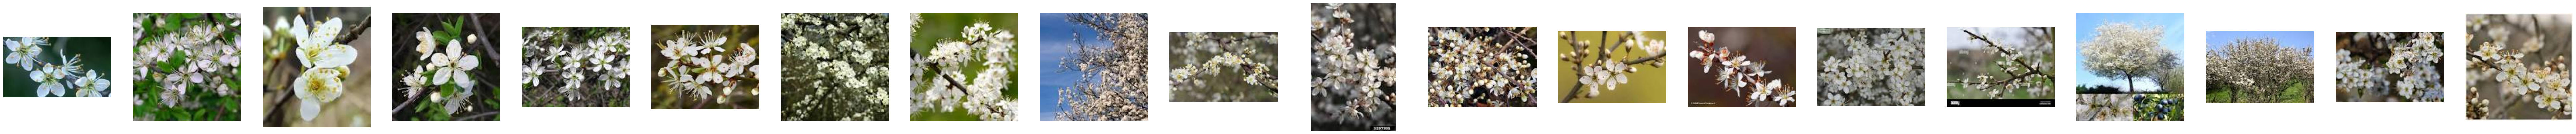

In [13]:
import requests
from bs4 import BeautifulSoup

def google_image_search(query):
  url = "https://www.google.com/search?q={}&source=lnms&tbm=isch".format(query)
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  image_elements = soup.find_all("img", class_="DS1iW")
  return [i['src'] for i in image_elements]

reference_images_url = google_image_search(f'{species.scientificNameWithoutAuthor} + flower')
reference_images = list(map(download_image, reference_images_url))
display_images(*reference_images)


## Run generation with ComfyUI

In [11]:
# Import workflows
sys.argv = ['']
from illustration_workflows import txt2img_workflow
from illustration_workflows import controlnet_workflow
comfyui_path = txt2img_workflow.find_path("ComfyUI")
rembg_session = rembg.new_session(model_name="isnet-general-use")


def run_txt2img_worflow(positive_prompt, negative_prompt):
    import random
    random.seed(len(positive_prompt))
    result = txt2img_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent


ComfyUI found: d:\workspace\ComfyUI
'd:\workspace\ComfyUI' added to sys.path


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


Total VRAM 6144 MB, total RAM 32725 MB
xformers version: 0.0.20
Set vram state to: NORMAL_VRAM
Device: cuda:0 NVIDIA GeForce GTX 1060 : native
Using xformers cross attention
ComfyUI found: d:\workspace\ComfyUI
'd:\workspace\ComfyUI' added to sys.path
** ComfyUI start up time: 2023-09-21 18:57:19.137484

Prestartup times for custom nodes:
   0.2 seconds: D:\workspace\ComfyUI\custom_nodes\ComfyUI-Manager

Could not find the extra_model_paths config file.
ComfyUI found: d:\workspace\ComfyUI
EP Error D:\a\_work\1\s\onnxruntime\core\session\provider_bridge_ort.cc:1131 onnxruntime::ProviderLibrary::Get [ONNXRuntimeError] : 1 : FAIL : LoadLibrary failed with error 126 "" when trying to load "c:\Anaconda3\envs\py10\lib\site-packages\onnxruntime\capi\onnxruntime_providers_tensorrt.dll"
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.


In [17]:
prompt = PROMPT.format(commonNames=', '.join(species.commonNames[:3]), scientificNameWithoutAuthor=species.scientificNameWithoutAuthor)
print(prompt)
# illustration, illustration_transparent = run_txt2img_worflow(positive_prompt=prompt, negative_prompt='')
# display_images(illustration, illustration_transparent)

In [23]:
reference_image = reference_images[1]
reference_image_name = f"reference_{species.scientificNameWithoutAuthor}.png"
reference_image.save(Path(comfyui_path) / "input" / reference_image_name)

import torch
torch.cuda.empty_cache()

def run_controlnet_worflow(positive_prompt, negative_prompt, reference_image_name):
    import random
    random.seed(len(positive_prompt))
    result = controlnet_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt, control_image=reference_image_name)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    mask = Image.open(Path(comfyui_path) / 'output' / result['controlnet_mask']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent, mask

reference_illustration, reference_illustration_transparent, mask = run_controlnet_worflow(positive_prompt=prompt, negative_prompt='', reference_image_name=reference_image_name)
display_images(reference_image, mask, reference_illustration, reference_illustration_transparent)

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: Tensor on device cuda:0 is not on the expected device meta!

## Upload result to Nature Go API

In [36]:
confirm_send = input()
if confirm_send == 'y':
    client.update_species_image(species_id=species.id, image=illustration, image_name='illustration')
    client.update_species_image(species_id=species.id, image=illustration_transparent, image_name='illustration_transparent')